In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
%matplotlib inline

# 514 Programming Assignment 2
#### Group: Rashaan, Ravi, David

Data additional information
Each record is an example of a hand consisting of five playing cards drawn from a standard deck of 52. 
Each card is described using two attributes (suit and rank), for a total of 10 predictive attributes. 
There is one Class attribute that describes the "Poker Hand". 
The order of cards is important, which is why there are 480 possible Royal Flush hands as compared to 4

#### Load dataset

In [154]:
# Column names for the dataset
# Define the column names for your dataset
columns = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'Class']

# Load your dataset
training_data = pd.read_csv('poker-hand-training-true.csv', header=None, names=columns)
testing_data = pd.read_csv('poker-hand-testing.csv', header=None, names=columns)

# Adjust the ranks of cards, specifically changing Ace from 1 to 14
def adjust_ranks(data):
    for i in range(1, 6):  # For each card in the hand
        data[f'C{i}'] = data[f'C{i}'].apply(lambda x: 14 if x == 1 else x)
    return data

# One-hot encode the suits of the cards
def one_hot_encode_suits(data):
    for i in range(1, 6):  # For each card in the hand
        data = pd.concat([data, pd.get_dummies(data[f'S{i}'], prefix=f'S{i}')], axis=1).drop([f'S{i}'], axis=1)
    return data

# Apply preprocessing steps
def preprocess_data(data):
    data = adjust_ranks(data)
    data = one_hot_encode_suits(data)
    return data

training_data_preprocessed = preprocess_data(training_data)
testing_data_preprocessed = preprocess_data(testing_data)


#### Final Preprocessed DATA

In [155]:
training_data_preprocessed.head()

,C1,C2,C3,C4,C5,Class,S1_1,S1_2,S1_3,S1_4,...,S3_3,S3_4,S4_1,S4_2,S4_3,S4_4,S5_1,S5_2,S5_3,S5_4
0,10,11,13,12,14,9,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
1,11,13,10,12,14,9,False,True,False,False,...,False,False,False,True,False,False,False,True,False,False
2,12,11,13,10,14,9,False,False,True,False,...,True,False,False,False,True,False,False,False,True,False
3,10,11,14,13,12,9,False,False,False,True,...,False,True,False,False,False,True,False,False,False,True
4,14,13,12,11,10,9,False,False,False,True,...,False,True,False,False,False,True,False,False,False,True


In [156]:
testing_data_preprocessed.head()

,C1,C2,C3,C4,C5,Class,S1_1,S1_2,S1_3,S1_4,...,S3_3,S3_4,S4_1,S4_2,S4_3,S4_4,S5_1,S5_2,S5_3,S5_4
0,14,13,4,3,12,0,True,False,False,False,...,False,False,False,True,False,False,True,False,False,False
1,12,2,11,5,5,1,False,False,True,False,...,True,False,False,False,False,True,False,True,False,False
2,9,6,4,2,9,1,True,False,False,False,...,False,False,False,False,True,False,False,False,True,False
3,4,13,13,14,6,1,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,10,7,2,11,9,0,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True


In [157]:
training_data_preprocessed.describe()

,C1,C2,C3,C4,C5,Class
count,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000,25010.000000
mean,8.025470,8.045982,7.999160,7.973211,7.986725,0.621152
std,3.746958,3.758723,3.743223,3.758728,3.748488,0.788361
min,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000
25%,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000
50%,8.000000,8.000000,8.000000,8.000000,8.000000,1.000000
75%,11.000000,11.000000,11.000000,11.000000,11.000000,1.000000
max,14.000000,14.000000,14.000000,14.000000,14.000000,9.000000


# Artificial Neural Network (ANN) - Part B

In [158]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras import initializers
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import mean_absolute_error,mean_squared_error,classification_report,confusion_matrix

##### PREPARE THE TRAINING AND TESTING SETS

In [159]:
x_train = training_data_preprocessed[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_train = pd.DataFrame(training_data_preprocessed['Class'])

x_test = testing_data_preprocessed[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_test = pd.DataFrame(testing_data_preprocessed['Class'])

##### Adjust the classes such that each card is mapped to either BAD, GOOD, or GREAT then one-hot encode classes

In [160]:
def adjust_class(data):
        bad,good,great = 0,4,9
        #BAD
        data['Class'] = data['Class'].apply(lambda x: bad if x == 0 else x)
        data['Class'] = data['Class'].apply(lambda x: bad if x == 1 else x)
        data['Class'] = data['Class'].apply(lambda x: bad if x == 2 else x)
        data['Class'] = data['Class'].apply(lambda x: bad if x == 3 else x)
        #GOOD
        data['Class'] = data['Class'].apply(lambda x: good if x == 4 else x)
        data['Class'] = data['Class'].apply(lambda x: good if x == 5 else x)
        data['Class'] = data['Class'].apply(lambda x: good if x == 6 else x)
        #GREAT
        data['Class'] = data['Class'].apply(lambda x: great if x == 7 else x)
        data['Class'] = data['Class'].apply(lambda x: great if x == 8 else x)
        data['Class'] = data['Class'].apply(lambda x: great if x == 9 else x)
        return data

def remove_val_df(df,v):
    temp_df = copy.deepcopy(adjust_class(df))   
    indexClass = temp_df[(temp_df['Class']==v)].index
    temp_df.drop(indexClass,inplace=True)
    return temp_df

def one_hot_encode_classes(data):
    data = pd.get_dummies(data,columns=['Class'])
    return data

In [161]:
df_rm_0 = remove_val_df(training_data_preprocessed,0)
df_rm_4 = remove_val_df(training_data_preprocessed,4)
df_rm_9 = remove_val_df(training_data_preprocessed,9)

In [162]:
# CLASS 1: ONLY GOOD AND GREAT ###########
x_train_0 = df_rm_0[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_train_0 = pd.DataFrame(df_rm_0['Class'])

x_test_0 = df_rm_0[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_test_0 = pd.DataFrame(df_rm_0['Class'])

# CLASS 2: ONLY BAD AND GREAT ###########
x_train_4 = df_rm_4[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_train_4 = pd.DataFrame(df_rm_4['Class'])

x_test_4 = df_rm_4[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_test_4 = pd.DataFrame(df_rm_4['Class'])

# CLASS 3: ONLY BAD AND GOOD ###########
x_train_9 = df_rm_9[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_train_9 = pd.DataFrame(df_rm_9['Class'])

x_test_9 = df_rm_9[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_test_9 = pd.DataFrame(df_rm_9['Class'])

# CLASS EC: ALL ###########
x_train_all = training_data_preprocessed[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_train_all = pd.DataFrame(training_data_preprocessed['Class'])

x_test_all = training_data_preprocessed[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_test_all = pd.DataFrame(training_data_preprocessed['Class'])

In [163]:
##### good and great 
x_train_float_0 = np.asarray(x_train_0).astype('float32') 

x_test_float_0 = np.asarray(x_test_0).astype('float32') 

y_train_one_hot_0 = np.asarray(one_hot_encode_classes(adjust_class(y_train_0))).astype('float32')
y_train_one_hot_0 = pd.DataFrame(y_train_one_hot_0, columns=['Good','Great'])

y_test_one_hot_0 = np.asarray(one_hot_encode_classes(adjust_class(y_test_0))).astype('float32')
y_test_one_hot_0 = pd.DataFrame(y_test_one_hot_0, columns=['Good','Great'])

##### bad and great 
x_train_float_4 = np.asarray(x_train_4).astype('float32') 

x_test_float_4 = np.asarray(x_test_4).astype('float32') 

y_train_one_hot_4 = np.asarray(one_hot_encode_classes(adjust_class(y_train_4))).astype('float32')
y_train_one_hot_4 = pd.DataFrame(y_train_one_hot_4, columns=['Bad','Great'])

y_test_one_hot_4 = np.asarray(one_hot_encode_classes(adjust_class(y_test_4))).astype('float32')
y_test_one_hot_4 = pd.DataFrame(y_test_one_hot_4, columns=['Bad','Great'])

##### bad and great 
x_train_float_9 = np.asarray(x_train_9).astype('float32') 

x_test_float_9  = np.asarray(x_test_9).astype('float32') 

y_train_one_hot_9  = np.asarray(one_hot_encode_classes(adjust_class(y_train_9))).astype('float32')
y_train_one_hot_9  = pd.DataFrame(y_train_one_hot_9, columns=['Bad','Good'])

y_test_one_hot_9  = np.asarray(one_hot_encode_classes(adjust_class(y_test_9))).astype('float32')
y_test_one_hot_9  = pd.DataFrame(y_test_one_hot_9, columns=['Bad','Good'])

##### ALLL 
x_train_float = np.asarray(x_train_all).astype('float32') 

x_test_float = np.asarray(x_test_all).astype('float32') 

y_train_one_hot = np.asarray(one_hot_encode_classes(adjust_class(y_train_all))).astype('float32')
y_train_one_hot = pd.DataFrame(y_train_one_hot, columns=['Bad','Good','Great'])

y_test_one_hot = np.asarray(one_hot_encode_classes(adjust_class(y_test_all))).astype('float32')
y_test_one_hot = pd.DataFrame(y_test_one_hot, columns=['Bad','Good','Great'])

#### Display one-hot classifications of output card classes

In [164]:
y_train_one_hot.describe()

,Bad,Good,Great
count,25010.000000,25010.000000,25010.000000
mean,0.992043,0.007317,0.000640
std,0.088838,0.085243,0.025277
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


In [165]:
y_train_one_hot.shape

(25010, 3)

In [166]:
y_test_one_hot.describe()

,Bad,Good,Great
count,25010.000000,25010.000000,25010.000000
mean,0.992043,0.007317,0.000640
std,0.088838,0.085243,0.025277
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


In [167]:
y_test_one_hot.shape

(25010, 3)

#### CREATE OUR ANN MODEL SKELETON 

#### Function to run Five-Fold CV on ANN 

In [168]:
def five_fold_CV(x_train,y_train,x_test,y_test,runs,batch,v,act='sigmoid',cols=['Bad','Good','Great'],shape=3):
    #MODEL
    model = Sequential()
    model.add(Dense(units=25,use_bias=True,kernel_initializer='ones',bias_initializer='ones',activation=act));
    model.add(Dense(shape,activation='softmax'))
    my_optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=my_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss',mode='min',patience=25,verbose=1)
    
    ### FOLDS ####
    folds = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_folds = folds.split(x_train,y_train)
    x_,y_,x_t,y_t = [],[],[],[]
    x_train = pd.DataFrame(x_train)
    y_train = pd.DataFrame(y_train)
    x_test = pd.DataFrame(x_test)
    y_test = pd.DataFrame(y_test)
    for i, (train_index, test_index) in enumerate(cv_folds):
        temp_x,temp_y = copy.deepcopy(x_train.iloc[train_index]),copy.deepcopy(y_train.iloc[train_index])
        temp_x_test,temp_y_test = copy.deepcopy(x_train.iloc[test_index]),copy.deepcopy(y_train.iloc[test_index])
        x_.append(temp_x)
        y_.append(temp_y)
        x_t.append(temp_x_test)
        y_t.append(temp_y_test)
        
    #FOLD 1
    x_train_float_fold1 = np.asarray(x_[0]).astype('float32') 
    
    y_train_float_fold1 = y_[0];
    y_test_float_fold1 = y_t[0];
    #y_train_float_fold1 = np.asarray(one_hot_encode_classes(adjust_class(y_[0]))).astype('float32')
    #y_train_float_fold1 = pd.DataFrame(y_train_float_fold1, columns=cols)
    
    x_test_float_fold1 = np.asarray(x_t[0]).astype('float32') 
    
    
    #y_test_float_fold1 = np.asarray(one_hot_encode_classes(adjust_class(y_t[0]))).astype('float32')
    #y_test_float_fold1 = pd.DataFrame(y_test_float_fold1, columns=cols)

    #FOLD 2
    x_train_float_fold2 = np.asarray(x_[1]).astype('float32') 
    
    y_train_float_fold2 = y_[1];
    y_test_float_fold2 = y_t[1];
    #y_train_float_fold2 = np.asarray(one_hot_encode_classes(adjust_class(y_[1]))).astype('float32')
    #y_train_float_fold2 = pd.DataFrame(y_train_float_fold2, columns=cols)
    
    x_test_float_fold2 = np.asarray(x_t[1]).astype('float32') 

    #y_test_float_fold2 = np.asarray(one_hot_encode_classes(adjust_class(y_t[1]))).astype('float32')
    #y_test_float_fold2 = pd.DataFrame(y_test_float_fold2, columns=cols)

    #FOLD 3
    x_train_float_fold3 = np.asarray(x_[2]).astype('float32') 
    
    y_train_float_fold3 = y_[2];
    y_test_float_fold3 = y_t[2];
    #y_train_float_fold3 = np.asarray(one_hot_encode_classes(adjust_class(y_[2]))).astype('float32')
    #y_train_float_fold3 = pd.DataFrame(y_train_float_fold3, columns=cols)
    
    x_test_float_fold3 = np.asarray(x_t[2]).astype('float32') 

    #y_test_float_fold3 = np.asarray(one_hot_encode_classes(adjust_class(y_t[2]))).astype('float32')
    #y_test_float_fold3 = pd.DataFrame(y_test_float_fold3, columns=cols)

    #FOLD 4
    x_train_float_fold4 = np.asarray(x_[3]).astype('float32') 
    
    y_train_float_fold4 = y_[3];
    y_test_float_fold4 = y_t[3];
    #y_train_float_fold4 = np.asarray(one_hot_encode_classes(adjust_class(y_[3]))).astype('float32')
    #y_train_float_fold4 = pd.DataFrame(y_train_float_fold4, columns=cols)
    
    x_test_float_fold4 = np.asarray(x_t[3]).astype('float32') 

    #y_test_float_fold4 = np.asarray(one_hot_encode_classes(adjust_class(y_t[3]))).astype('float32')
    #y_test_float_fold4 = pd.DataFrame(y_test_float_fold4, columns=cols)

    #FOLD 5
    x_train_float_fold5 = np.asarray(x_[4]).astype('float32') 
    
    y_train_float_fold5 = y_[4];
    y_test_float_fold5 = y_t[4];
    #y_train_float_fold5 = np.asarray(one_hot_encode_classes(adjust_class(y_[4]))).astype('float32')
    #y_train_float_fold5 = pd.DataFrame(y_train_float_fold5, columns=cols) 
    
    x_test_float_fold5 = np.asarray(x_t[4]).astype('float32') 

    #y_test_float_fold5 = np.asarray(one_hot_encode_classes(adjust_class(y_t[4]))).astype('float32')
    #y_test_float_fold5 = pd.DataFrame(y_test_float_fold5, columns=cols)
    
    ### TESTING ###
    loss = []
    scores = []
    
    x_test_float = np.asarray(x_test).astype('float32')
    x_test = x_test_float
    
    #y_test_one_hot = np.asarray(one_hot_encode_classes(adjust_class(y_test))).astype('float32')
    #y_test_one_hot = pd.DataFrame(y_test_one_hot, columns=cols)
    y_test = y_test_one_hot
    
    #First CV FOLD
    print("First CV FOLD")
    x=x_train_float_fold1
    y=y_train_float_fold1
    model.fit(x=x,y=y,epochs=runs,validation_data=(x_test_float_fold1,y_test_float_fold1),batch_size=batch,callbacks=[early_stop],verbose=v)
    loss.append(pd.DataFrame(model.history.history))
    scores.append(model.evaluate(x_test_float_fold1,y_test_float_fold1,verbose=0))
    model.save('first_cv.keras')
    del model #clear cache
    
    #Second CV Fold
    print("\nSecond CV FOLD")
    model = load_model('first_cv.keras')
    x=x_train_float_fold2
    y=y_train_float_fold2
    model.fit(x=x,y=y,epochs=runs,validation_data=(x_test_float_fold2,y_test_float_fold2),batch_size=batch,callbacks=[early_stop],verbose=v)
    loss.append(pd.DataFrame(model.history.history))
    scores.append(model.evaluate(x_test_float_fold2,y_test_float_fold2,verbose=0))
    model.save('second_cv.keras')
    del model #clear cache
    
    #Third CV Fold
    print("\nThird CV FOLD")
    model = load_model('second_cv.keras')
    x=x_train_float_fold3
    y=y_train_float_fold3
    model.fit(x=x,y=y,epochs=runs,validation_data=(x_test_float_fold3,y_test_float_fold3),batch_size=batch,callbacks=[early_stop],verbose=v)
    loss.append(pd.DataFrame(model.history.history))
    scores.append(model.evaluate(x_test_float_fold3,y_test_float_fold3,verbose=0))
    model.save('third_cv.keras')
    del model #clear cache
    
    #Fourth CV Fold
    print("\nFourth CV FOLD")
    model = load_model('third_cv.keras')
    x=x_train_float_fold4
    y=y_train_float_fold4
    model.fit(x=x,y=y,epochs=runs,validation_data=(x_test_float_fold4,y_test_float_fold4),batch_size=batch,callbacks=[early_stop],verbose=v)
    loss.append(pd.DataFrame(model.history.history))
    scores.append(model.evaluate(x_test_float_fold4,y_test_float_fold4,verbose=0))
    model.save('fourth_cv.keras')
    del model #clear cache
    
    #Fifth CV Fold
    print("\nFifth CV FOLD")
    model = load_model('fourth_cv.keras')
    x=x_train_float_fold5
    y=y_train_float_fold5
    model.fit(x=x,y=y,epochs=runs,validation_data=(x_test_float_fold5,y_test_float_fold5),batch_size=batch,callbacks=[early_stop],verbose=v)
    loss.append(pd.DataFrame(model.history.history))
    scores.append(model.evaluate(x_test_float_fold5,y_test_float_fold5,verbose=0))
    model.save('fifth_cv.keras')
    
    return model,loss,scores

In [169]:
x_train = x_train_float
y_train = y_train_one_hot
x_test = x_train_float
y_test = y_test_one_hot
model,loss,scores = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='sigmoid')
model2,loss2,scores2 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='relu')
model3,loss3,scores3 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='tanh')
model4,loss4,scores4 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='leaky_relu')
model5,loss5,scores5 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='linear')

First CV FOLD

Second CV FOLD
Epoch 85: early stopping

Third CV FOLD

Fourth CV FOLD
Epoch 74: early stopping

Fifth CV FOLD
Epoch 25: early stopping
First CV FOLD

Second CV FOLD
Epoch 26: early stopping

Third CV FOLD
Epoch 56: early stopping

Fourth CV FOLD
Epoch 36: early stopping

Fifth CV FOLD
Epoch 37: early stopping
First CV FOLD

Second CV FOLD

Third CV FOLD

Fourth CV FOLD
Epoch 38: early stopping

Fifth CV FOLD
Epoch 25: early stopping
First CV FOLD
Epoch 41: early stopping

Second CV FOLD
Epoch 26: early stopping

Third CV FOLD
Epoch 27: early stopping

Fourth CV FOLD
Epoch 33: early stopping

Fifth CV FOLD
Epoch 79: early stopping
First CV FOLD
Epoch 28: early stopping

Second CV FOLD
Epoch 25: early stopping

Third CV FOLD
Epoch 31: early stopping

Fourth CV FOLD
Epoch 32: early stopping

Fifth CV FOLD
Epoch 28: early stopping


In [170]:
x_train = x_train_float_0
y_train = y_train_one_hot_0
x_test = x_test_float_0
y_test = y_test_one_hot_0
col = ['Good','Great']
s=2
model_0,loss_0,scores_0 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='sigmoid',cols=col,shape=s)
model2_0,loss2_0,scores2_0 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='relu',cols=col,shape=s)
model3_0,loss3_0,scores3_0 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='tanh',cols=col,shape=s)
model4_0,loss4_0,scores4_0 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='leaky_relu',cols=col,shape=s)
model5_0,loss5_0,scores5_0 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='linear',cols=col,shape=s)

First CV FOLD
Epoch 77: early stopping

Second CV FOLD
Epoch 42: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 25: early stopping

Fifth CV FOLD
Epoch 26: early stopping
First CV FOLD
Epoch 52: early stopping

Second CV FOLD
Epoch 25: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 38: early stopping

Fifth CV FOLD
Epoch 33: early stopping
First CV FOLD

Second CV FOLD

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 25: early stopping

Fifth CV FOLD
Epoch 26: early stopping
First CV FOLD
Epoch 62: early stopping

Second CV FOLD
Epoch 25: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 43: early stopping

Fifth CV FOLD
Epoch 35: early stopping
First CV FOLD
Epoch 28: early stopping

Second CV FOLD
Epoch 25: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 25: early stopping

Fifth CV FOLD
Epoch 26: early stopping


In [171]:
def score_sums(data):
    s_sum = sum([data[i][1] for i in range(len(data))])/len(data)
    return s_sum

In [172]:
print(score_sums(scores_0))
print(score_sums(scores2_0))
print(score_sums(scores3_0))
print(score_sums(scores4_0))
print(score_sums(scores5_0))

0.9198717832565307
0.9198717832565307
0.9198717832565307
0.9198717832565307
0.9198717832565307


In [173]:
x_train = x_train_float_4
y_train = y_train_one_hot_4
x_test = x_test_float_4
y_test = y_test_one_hot_4
col = ['Bad','Great']
s=2
model_4,loss_4,scores_4 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='sigmoid',cols=col,shape=s)
model2_4,loss2_4,scores2_4 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='relu',cols=col,shape=s)
model3_4,loss3_4,scores3_4 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='tanh',cols=col,shape=s)
model4_4,loss4_4,scores4_4 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='leaky_relu',cols=col,shape=s)
model5_4,loss5_4,scores5_4 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='linear',cols=col,shape=s)

First CV FOLD

Second CV FOLD

Third CV FOLD

Fourth CV FOLD
Epoch 25: early stopping

Fifth CV FOLD
First CV FOLD

Second CV FOLD
Epoch 25: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 25: early stopping

Fifth CV FOLD
Epoch 27: early stopping
First CV FOLD

Second CV FOLD
Epoch 25: early stopping

Third CV FOLD

Fourth CV FOLD
Epoch 25: early stopping

Fifth CV FOLD
First CV FOLD

Second CV FOLD
Epoch 25: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 25: early stopping

Fifth CV FOLD
Epoch 30: early stopping
First CV FOLD
Epoch 28: early stopping

Second CV FOLD
Epoch 25: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 25: early stopping

Fifth CV FOLD


In [174]:
print(score_sums(scores_4))
print(score_sums(scores2_4))
print(score_sums(scores3_4))
print(score_sums(scores4_4))
print(score_sums(scores5_4))

0.9993555545806885
0.9993555545806885
0.9993555545806885
0.9993555545806885
0.9993555545806885


In [175]:
x_train = x_train_float_9
y_train = y_train_one_hot_9
x_test = x_test_float_9
y_test = y_test_one_hot_9
col = ['Bad','Good']
s=2
model_9,loss_9,scores_9 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='sigmoid',cols=col,shape=s)
model2_9,loss2_9,scores2_9 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='relu',cols=col,shape=s)
model3_9,loss3_9,scores3_9 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='tanh',cols=col,shape=s)
model4_9,loss4_9,scores4_9 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='leaky_relu',cols=col,shape=s)
model5_9,loss5_9,scores5_9 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='linear',cols=col,shape=s)

First CV FOLD

Second CV FOLD
Epoch 25: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 26: early stopping

Fifth CV FOLD
Epoch 26: early stopping
First CV FOLD
Epoch 32: early stopping

Second CV FOLD
Epoch 25: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD

Fifth CV FOLD
First CV FOLD
Epoch 70: early stopping

Second CV FOLD
Epoch 25: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 26: early stopping

Fifth CV FOLD
Epoch 26: early stopping
First CV FOLD
Epoch 34: early stopping

Second CV FOLD
Epoch 25: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD

Fifth CV FOLD
First CV FOLD

Second CV FOLD
Epoch 25: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 26: early stopping

Fifth CV FOLD
Epoch 29: early stopping


In [176]:
print(score_sums(scores_9))
print(score_sums(scores2_9))
print(score_sums(scores3_9))
print(score_sums(scores4_9))
print(score_sums(scores5_9))

0.9926782727241517
0.9926782727241517
0.9926782727241517
0.9926782727241517
0.9926782727241517


# SCORING and RUNTIME

#### First Class

In [199]:
%%time
x_train = x_train_float_0
y_train = y_train_one_hot_0
x_test = x_test_float_0
y_test = y_test_one_hot_0
col = ['Good','Great']
s=2
model3_0,loss3_0,scores3_0 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='tanh',cols=col,shape=s)

First CV FOLD
Epoch 49: early stopping

Second CV FOLD
Epoch 29: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 25: early stopping

Fifth CV FOLD
Epoch 26: early stopping
CPU times: user 8.45 s, sys: 904 ms, total: 9.35 s
Wall time: 8.47 s


In [200]:
%%time
y_=model3_0.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
CPU times: user 89 ms, sys: 5.67 ms, total: 94.7 ms
Wall time: 90.9 ms


In [201]:
model3_0.evaluate(x_test,y_test,verbose=0)

[0.2595433294773102, 0.9195979833602905]

In [202]:
score_sums(scores3_0)

0.9198717832565307

#### Second Class

In [203]:
%%time
x_train = x_train_float_0
y_train = y_train_one_hot_0
x_test = x_test_float_0
y_test = y_test_one_hot_0
col = ['Bad','Great']
s=2
model3_4,loss3_4,scores3_4 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='tanh',cols=col,shape=s)

First CV FOLD

Second CV FOLD

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 25: early stopping

Fifth CV FOLD
Epoch 39: early stopping
CPU times: user 13 s, sys: 1.51 s, total: 14.5 s
Wall time: 12.9 s


In [204]:
%%time
y_=model3_4.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
CPU times: user 100 ms, sys: 7.48 ms, total: 108 ms
Wall time: 104 ms


In [205]:
model3_4.evaluate(x_test,y_test,verbose=0)

[0.25950461626052856, 0.9195979833602905]

In [206]:
score_sums(scores3_4)

0.9198717832565307

#### Third Class

In [207]:
%%time
x_train = x_train_float_0
y_train = y_train_one_hot_0
x_test = x_test_float_0
y_test = y_test_one_hot_0
col = ['Good','Great']
s=2
model3_9,loss3_9,scores3_9 = five_fold_CV(x_train,y_train,x_test,y_test,100,5000,0,act='tanh',cols=col,shape=s)

First CV FOLD
Epoch 89: early stopping

Second CV FOLD
Epoch 27: early stopping

Third CV FOLD
Epoch 25: early stopping

Fourth CV FOLD
Epoch 25: early stopping

Fifth CV FOLD
Epoch 26: early stopping
CPU times: user 10.2 s, sys: 1.1 s, total: 11.3 s
Wall time: 10.4 s


In [208]:
%%time
y_=model3_9.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
CPU times: user 99.7 ms, sys: 6.5 ms, total: 106 ms
Wall time: 102 ms


In [209]:
model3_9.evaluate(x_test,y_test,verbose=0)

[0.2620137631893158, 0.9195979833602905]

In [210]:
score_sums(scores3_9)

0.9198717832565307

In [211]:
def plot_cv_loss(loss,title='title'):
    colors = ['r','g','b','k','c','m']
    x,y,count = 0,0,0
    for i in range(len(loss)):
        for j in range(len(loss[i]['val_loss'])):
            x = count
            y = loss[i]['val_loss'][j]
            count+=1
            if(j==0):
                plt.plot(x,y,colors[i],ls='-',marker='o',label='fold '+str(i))
            else:
                plt.plot(x,y,colors[i],ls='-',marker='o')
    plt.title("ANN Model 5Fold-CV: Val_Loss vs Iteration: " + str(title))
    plt.xlabel("iteration")
    plt.ylabel("val_loss")
    plt.legend(loc="upper right")
    plt.show()

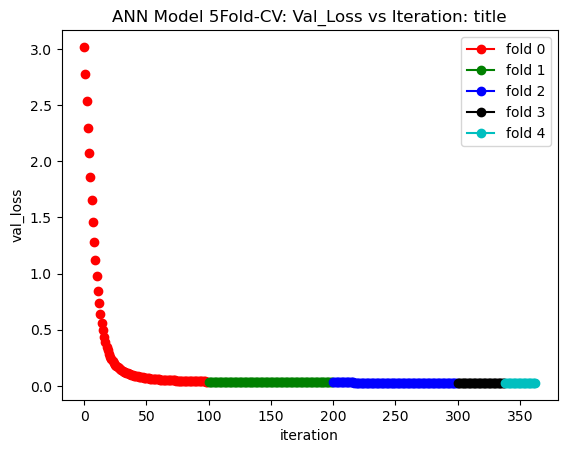

In [190]:
plot_cv_loss(loss3)

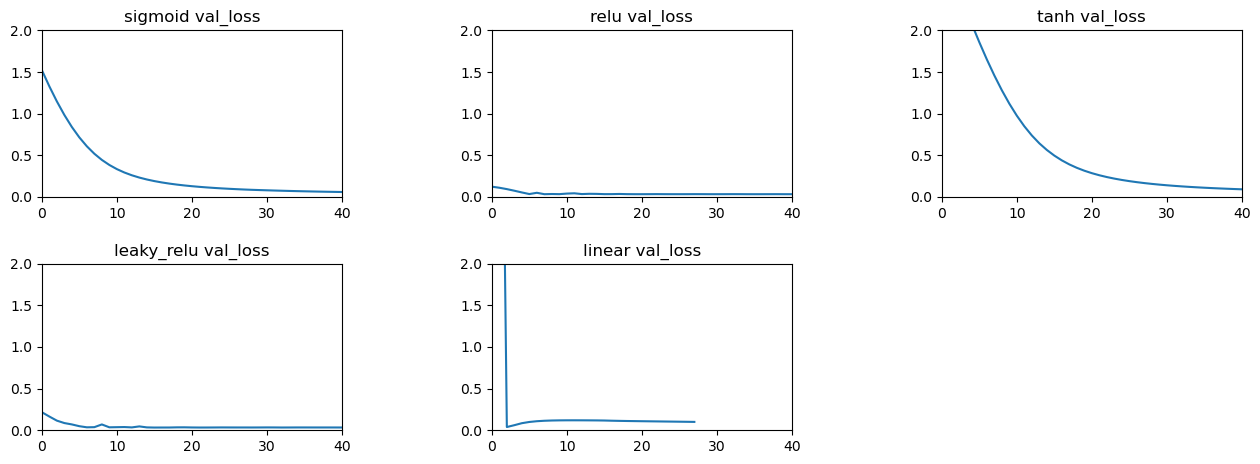

In [191]:
figure,axis=plt.subplots(2,3)
magmax = 1
axis[0,0].plot(pd.DataFrame(loss[0]['val_loss']))
axis[0,0].set_title("sigmoid val_loss")
axis[0,0].set_xlim([0,40])
axis[0,0].set_ylim([0,2])

axis[0,1].plot(pd.DataFrame(loss2[0]['val_loss']))
axis[0,1].set_title("relu val_loss")
axis[0,1].set_xlim([0,40])
axis[0,1].set_ylim([0,2])

axis[0,2].plot(pd.DataFrame(loss3[0]['val_loss']))
axis[0,2].set_title("tanh val_loss")
axis[0,2].set_xlim([0,40])
axis[0,2].set_ylim([0,2])

axis[1,0].plot(pd.DataFrame(loss4[0]['val_loss']))
axis[1,0].set_title("leaky_relu val_loss")
axis[1,0].set_xlim([0,40])
axis[1,0].set_ylim([0,2])

axis[1,1].plot(pd.DataFrame(loss5[0]['val_loss']))
axis[1,1].set_title("linear val_loss")
axis[1,1].set_xlim([0,40])
axis[1,1].set_ylim([0,2])

axis[1,2].remove()

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.5,top=0.9, wspace=0.5, hspace=0.4)
figure.set_figheight(5)
figure.set_figwidth(30)

plt.show()

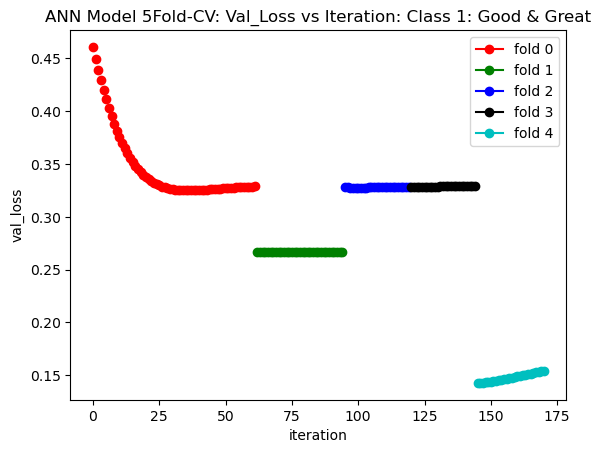

In [192]:
plot_cv_loss(loss3_0,"Class 1: Good & Great")

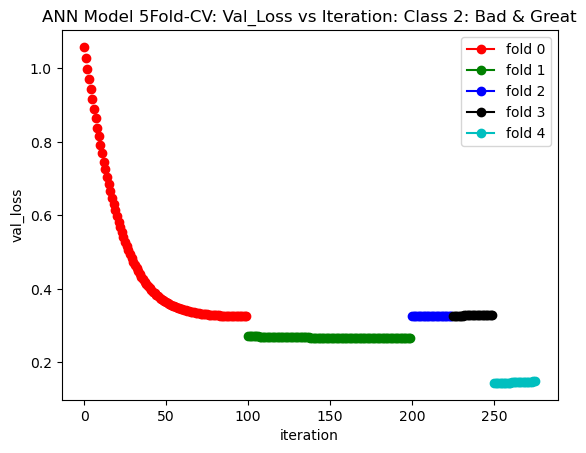

In [193]:
plot_cv_loss(loss3_4,"Class 2: Bad & Great")

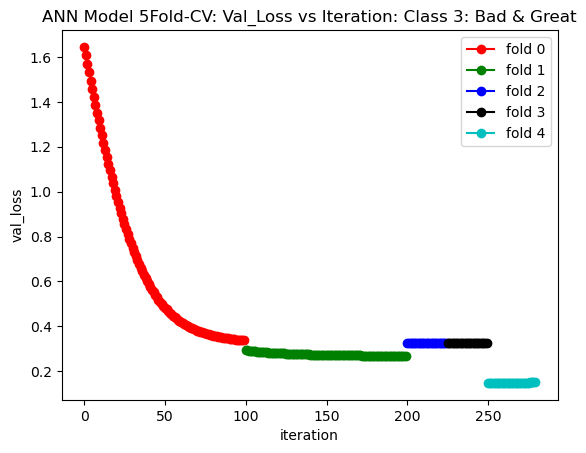

In [194]:
plot_cv_loss(loss3_9,"Class 3: Bad & Great")

#### Use the best model to train on the entire training dataset

In [195]:
model = load_model('fifth_cv.keras')

In [196]:
### TRAIN
x = np.asarray(x_train).astype('float32')

y_train_one_hot = np.asarray(one_hot_encode_classes(adjust_class(y_train))).astype('float32')
y = pd.DataFrame(y_train_one_hot, columns=['Bad','Good','Great'])

#### TEST
x_test_float = np.asarray(x_test).astype('float32')
x_test = x_test_float
    
y_test_one_hot = np.asarray(one_hot_encode_classes(adjust_class(y_test))).astype('float32')
y_test_one_hot = pd.DataFrame(y_test_one_hot, columns=['Bad','Good','Great'])
y_test = y_test_one_hot

early_stop = EarlyStopping(monitor='val_loss',mode='min',patience=25,verbose=1)
model.fit(x=x,y=y,epochs=500,validation_data=(x_test,y_test),batch_size=5000,callbacks=[early_stop],verbose=1)
loss.append(pd.DataFrame(model.history.history))
scores.append(model.evaluate(x_test,y_test,verbose=0))
model.save('final_model_entire_train.keras')

KeyError: 'Class'